# CS 228 Final Project
## Enhancing Image Captioning with Deep Learning Models
### Saul Gonzalez - sgonz081
### Shaheriar Malik - smali032

Dataset: https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset

Image captioning is a difficult task that is one step above image classification since we are
generating an actual text description of each image. So, deep learning would be an obvious choice in this case since generating text for a variable input image is a difficult task that would require a complex model.


In [28]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

import random
import os
import natsort
import cv2
from textwrap import wrap
from IPython.display import clear_output

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
raw_df = pd.read_csv('/content/drive/MyDrive/ImageCaptioningDataset/results.csv', sep='|')
raw_df.drop([' comment_number'],axis=1, inplace=True)
raw_df.columns = raw_df.columns.str.replace(' ', '')
raw_df

image_name                                            comment
0       1000092795.jpg   Two young guys with shaggy hair look at their...
1       1000092795.jpg   Two young , White males are outside near many...
2       1000092795.jpg   Two men in green shirts are standing in a yard .
3       1000092795.jpg       A man in a blue shirt standing in a garden .
4       1000092795.jpg            Two friends enjoy time spent together .
...                ...                                                ...
158910   998845445.jpg   A man in shorts and a Hawaiian shirt leans ov...
158911   998845445.jpg   A young man hanging over the side of a boat ,...
158912   998845445.jpg   A man is leaning off of the side of a blue an...
158913   998845445.jpg   A man riding a small boat in a harbor , with ...
158914   998845445.jpg   A man on a moored blue and white boat with hi...

[158915 rows x 2 columns]

In [4]:
# read, resize and zero pad images. Returns image tensor [3, 256, 256]
def readImage(path):
    desired_size = 256 # 256 x 256
    image = cv2.imread(path)
    old_size = image.shape[:2]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    image = cv2.resize(image, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    new_im = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    transform = transforms.ToTensor()
    tensor = transform(new_im)
    return tensor

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    num = temp_df.shape[0]
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(num):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
        image = readImage(f"/content/drive/MyDrive/ImageCaptioningDataset/flickr30k_images/{temp_df.image_name[i]}")
        plt.imshow(image.permute(1, 2, 0))
        plt.title("\n".join(wrap(temp_df.comment[i], 30)))

#num = 5
#display_images(raw_df.sample(num))

In [ ]:
#X = np.zeros((158915,3,256,256))
#y = list()
#for i in range(len(raw_df)):
#  image = readImage(f"/content/drive/MyDrive/ImageCaptioningDataset/flickr30k_images/{raw_df.image_name[i]}")
#  X[i] = np.array(image)
#  y.append(raw_df.comment[i])
#  clear_output()
#  print(i)


In [5]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = os.listdir(data_dir)  # Assumes images are directly under data_dir

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, self.image_paths[idx])
        image = Image.open(image_path).convert("RGB")
        file_name = self.image_paths[idx]
        
        if self.transform is not None:
            image = self.transform(image)
        
        # Return the processed image and any associated labels
        return image, file_name


In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

data_dir = '/content/drive/MyDrive/ImageCaptioningDataset/flickr30k_images/'  # Replace with your dataset directory
dataset = CustomDataset(data_dir, transform=transform)

In [34]:
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

 A man is skiing down a mountain with another large mountain behind him and a river between the mountains .


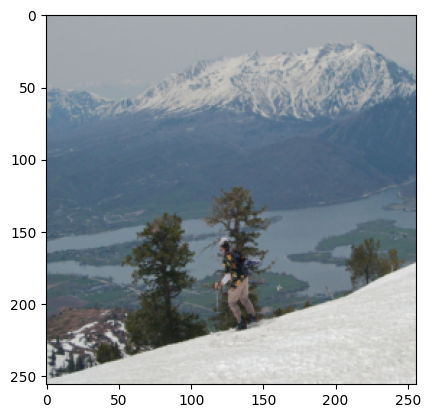

KeyboardInterrupt: ignored

In [ ]:
import time
i = 0
for img, file_name in dataloader:
  clear_output()
  #print(label[0])
  #print(raw_df['image_name'])
  plt.imshow(img[0].permute(1,2,0))
  print(list(raw_df.loc[raw_df['image_name'] == file_name[0]].comment)[0])
  i+=5
  plt.show()
  time.sleep(1)

## Convolutional Neual Network (CNN)

In [31]:
raw_df['words'] = raw_df['comment'].str.split()
df_exploded = raw_df.explode('words')
vocab_size = df_exploded['words'].nunique()

In [29]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(ImageCaptioningModel, self).__init__()
        
        # Load the pretrained ResNet-101 model
        self.resnet = models.resnet101(pretrained=False)
        self.resnet.fc = nn.Linear(2048, embed_size)
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, images, captions):
        features = self.resnet(images)
        features = features.unsqueeze(1)
        
        embeddings = self.embedding(captions)
        
        combined = torch.cat((features, embeddings), dim=1)
        
        lstm_out, _ = self.lstm(combined)
        
        outputs = self.fc(lstm_out)
        
        return outputs

In [32]:
embed_size = 256  # Size of the word embedding
hidden_size = 512  # Size of the LSTM hidden state

model = ImageCaptioningModel(embed_size, hidden_size, vocab_size)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

for epoch in range(num_epochs):
    for images, names in dataloader:
        # Move images and captions to device (e.g., GPU)
        images = images.to(device)
        print(images.size())
        names = list(names)
        captions_col = raw_df.loc[raw_df['image_name'].isin(names)]['comment']
        print(type(captions_col.values))
        # note to self: tokenize captions tomorrow -_-
        captions = torch.tensor(captions_col.values)
        print(captions)
        captions = captions.to(device)
        
        # Forward pass
        outputs = model(images, captions[:, :-1])
        
        # Reshape captions for loss calculation
        targets = captions[:, 1:].reshape(-1)
        
        # Compute loss
        loss = criterion(outputs.reshape(-1, vocab_size), targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print the loss
        if i % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

torch.Size([64, 3, 256, 256])
<class 'numpy.ndarray'>


TypeError: ignored